In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

import nltk
nltk.download('stopwords')

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 21.8 s, sys: 964 ms, total: 22.7 s
Wall time: 22.8 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 12s, sys: 114 ms, total: 3min 12s
Wall time: 3min 12s


А теперь в 3 строчки обучим нашу модель

In [11]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

In [14]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
from gensim.models import LdaModel

In [16]:
LdaModel?

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 19s, sys: 2min 50s, total: 4min 10s
Wall time: 44.8 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(12, 0.3917527), (19, 0.55396694), (21, 0.03093842)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сша американский экономика система экономический двигатель испытание
topic_1: ребёнок всё рубль случай месяц управление проблема
topic_2: вода обнаружить пенсия экипаж nn км час
topic_3: станция житель nn гражданин центр население день
topic_4: университет исследование товар лаборатория расследование доказательство налог
topic_5: исследование статья тыс помощь автор планета дом
topic_6: ракета энергия диск сход моделирование межконтинентальный секунда
topic_7: банк рынок россия китай миссия первый инвестиция
topic_8: научный путин исследование операция государство военный мозг
topic_9: россия российский эксперт новый газ nn развитие
topic_10: законодательство больной рейтинг карта место млн список
topic_11: военный санкция россия фестиваль российский соглашение договор
topic_12: погибнуть тело произойти космос nn километр жертва
topic_13: земля район территория произойти армия пострадать писать
topic_14: nn гражданин экономический палата реформа иран налоговый
topic_15: журнал

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.107829,0.0,...,0.0,0.0,0.0,0.0,0.090004,0.000000,0.00000,0.0,0.0,0.000000
1,4896,0.0,0.0,0.0,0.554546,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.343227,0.000000,0.00000,0.0,0.0,0.000000
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.554048,0.000000,0.03094,0.0,0.0,0.000000
3,4898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.900933,0.000000,0.00000,0.0,0.0,0.000000
4,4899,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.635721,0.00000,0.0,0.0,0.087807


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.07592892, 0.        ,
       0.        , 0.01803679, 0.04469977, 0.04005004, 0.09442181,
       0.05754084, 0.02905577, 0.15623578, 0.        , 0.        ,
       0.23244675, 0.        , 0.        , 0.        , 0.11970851,
       0.12236974, 0.        , 0.        , 0.        , 0.        ])

In [26]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [27]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, statistic='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if statistic == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif statistic == 'median':
        user_vector = np.median(user_vector, 0)
    elif statistic == 'max':
        user_vector = np.max(user_vector, 0)
    else:
        print('Некорректное значение параметра statistic - допустимые значения: "mean", "median", "max"')
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class UserEmbedding(BaseEstimator, TransformerMixin):

    def __init__(self, statistic='mean'):
        self.statistic = statistic

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        user_embeddings = pd.DataFrame([i for i in X['articles'].apply(lambda x: get_user_embedding(x, self.statistic), 1)])
        user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
        user_embeddings['uid'] = X['uid'].values
        user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
        return user_embeddings
    
    
class MergeTarget(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        target = pd.read_csv("users_churn.csv")
        X = pd.merge(X, target, 'left')
        return X

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [31]:
import itertools

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ROC-AUC=0.9398360369788942            Best Threshold=0.26889371941780416, F-Score=0.665,            Precision=0.626, Recall=0.710
Confusion matrix, without normalization
[[1651  104]
 [  72  173]]


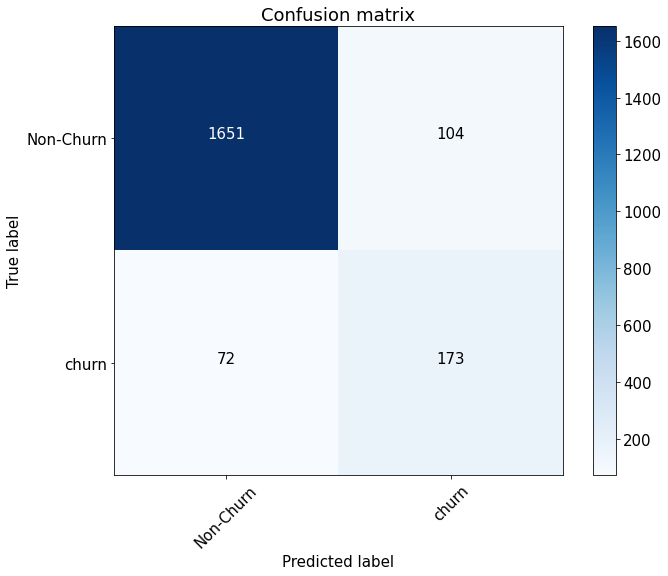

ROC-AUC=0.9761404732833304            Best Threshold=0.28681660662647857, F-Score=0.775,            Precision=0.707, Recall=0.857
Confusion matrix, without normalization
[[1668   87]
 [  36  209]]


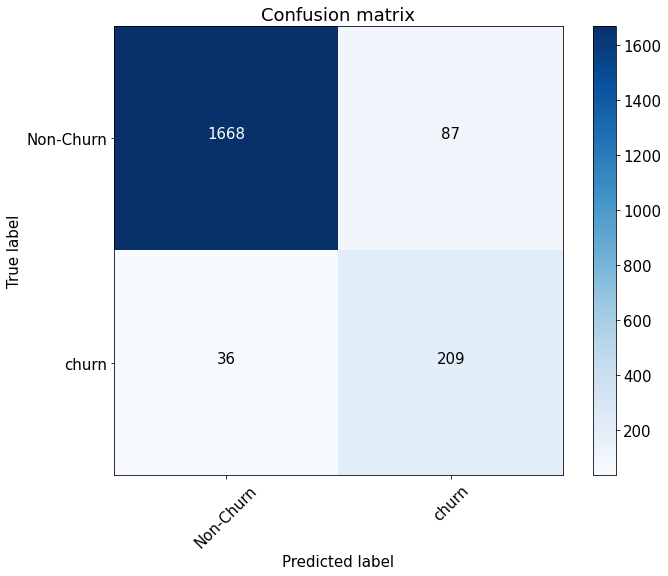

ROC-AUC=0.9762451305308448            Best Threshold=0.3821938374608481, F-Score=0.793,            Precision=0.803, Recall=0.784
Confusion matrix, without normalization
[[1708   47]
 [  54  191]]


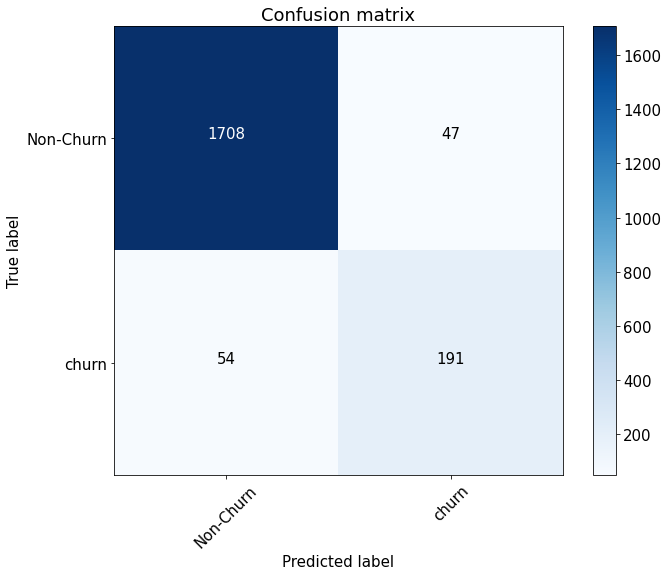

In [33]:
table_metrics = []
list_metrics = ['mean', 'median', 'max']
for el in list_metrics:
    pipeline = Pipeline([
        ('user_embedding', UserEmbedding(statistic=el)),
        ('dataset', MergeTarget())
    ])
    X = pipeline.transform(users)
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logreg = LogisticRegression()
    #обучим 
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC-AUC={roc_auc}\
            Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f},\
            Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
    table_metrics.append([roc_auc, thresholds[ix], fscore[ix], precision[ix], recall[ix]])
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

In [34]:
table_metrics = np.array(table_metrics)
table = pd.DataFrame(table_metrics, list_metrics, ['ROC-AUC', 'Best Threshold', 'F-Score', 'Precision', 'Recall'])
table

,ROC-AUC,Best Threshold,F-Score,Precision,Recall
mean,0.939836,0.268894,0.665392,0.625899,0.710204
median,0.976140,0.286817,0.774908,0.707071,0.857143
max,0.976245,0.382194,0.793388,0.803347,0.783673


Как я понимаю, в данной задаче усреднения векторов занижают реальную заинтересованность в той или иной тематике, т.к. человек может читать статьи на две противоположные темы, что дает нам в одной статье условно вектор [0, 0.05, 0.14, 0.855], а во второй [0.7, 0.2, 0.1, 0]. При большом количестве статей разброс увеличивается, что искажает реальную заинтересованность. Использование медианы немного скрашивает искаженность по тем же причинам, по которым ее лучше использовать на выборках с выбросами. Лучший результат дает использование максимального значения, но мне кажется, что при реально большом количестве статей у юзера это может сыграть злую шутку - условно прочитано 100 статей, одна была по приколу про гороскопы прочитана, а в векторе окажется значение как раз с этой статьи, но оно не будет реально отображать заинтересованность в данной тематике. Поэтому есть подозрение, что на реальных данных, где у юзеров много прочитано статей есть резон использовать именно медиану - будет менее искаженный результат.